## ZFNet - Visualizing and understanding CNNs

#### Paper Summary

This paper is more of a science behind CNN, as in it lays out why CNN are more suitable for classifying images. The paper uses the same AlexNet architecture from 2011 Paper. Using that architecture, the authors visualize the filters of CNN and what they are learning in each layer. How these basic patterns learned in first, second layers help in identifying complex patterns down the line.

Apart from the original alexnet model, the authors experimented with some ideas on the original model itself which caused issues to original model. They explored different architectures which helped them outperform original AlexNet and generalization ability of the model to other datasets such as caltech dataset.

Main observations/changes that authors made to the original model or observed from the new model are -
- Along with Convnets used DeConvnet to visualize what each layer filter was learning from the data.
- Used unpooling, rectification and transposed version of filters for the DeConvnet.
- Observed by visualizing the first and second layers of Krizhevsky's architecture various problems are apparent. The first layer filters are a mix of extremely high and low frequency information, with little coverage of the mid frequencies.  
- Additionally, the 2nd layer visualization shows aliasing artifacts caused by the large stride 4 used in the 1st layer convolutions.   
- To  remedy  these problems,
   - reduced the 1st layer filter size from 11x11 to 7x7 and 
   - made the stride of the convolution  2,  rather  than  4. This new architecture retains much more information in the 1st and 2nd layer features.

### What's in this notebook ?
Here, I will try to replicate filter visulaization on pretrained VGG model, inbuilt in keras as training a model on Imagenet takes lot of time and resuources. Currently looking only on reproducing the filter visualization part from the paper. Filters may/may not look as given in the paper as VGG and CNN model used by the authors are quite different. VGG was made after this paper was published.

Majority code of this notebook is highly inspired and taken from Fchollet's book - Deep Learning with Python

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
!!wget https://53744bf91d44b81762e0-fbbc959d4e21c00b07dbe9c75f9c0b63.ssl.cf3.rackcdn.com/media/C3/C364DCA8-6CEB-4340-8163-A0D05BC78D6E/Presentation.Large/Hyacinth-macaw-portrait.jpg

['--2018-12-14 16:27:33--  https://53744bf91d44b81762e0-fbbc959d4e21c00b07dbe9c75f9c0b63.ssl.cf3.rackcdn.com/media/C3/C364DCA8-6CEB-4340-8163-A0D05BC78D6E/Presentation.Large/Hyacinth-macaw-portrait.jpg',
 'Resolving 53744bf91d44b81762e0-fbbc959d4e21c00b07dbe9c75f9c0b63.ssl.cf3.rackcdn.com (53744bf91d44b81762e0-fbbc959d4e21c00b07dbe9c75f9c0b63.ssl.cf3.rackcdn.com)... 23.62.25.221',
 'Connecting to 53744bf91d44b81762e0-fbbc959d4e21c00b07dbe9c75f9c0b63.ssl.cf3.rackcdn.com (53744bf91d44b81762e0-fbbc959d4e21c00b07dbe9c75f9c0b63.ssl.cf3.rackcdn.com)|23.62.25.221|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 51770 (51K) [image/jpeg]',
 'Saving to: ‘Hyacinth-macaw-portrait.jpg’',
 '',
 '     0K .......... .......... .......... .......... .......... 98%  312M 0s',
 '    50K                                                       100% 1062G=0s',
 '',
 '2018-12-14 16:27:34 (315 MB/s) - ‘Hyacinth-macaw-portrait.jpg’ saved [51770/51770]',
 '']

In [3]:
img_path = '/home/ubuntu/Deep-Learning-Papers-Implementation/Architectures/Hyacinth-macaw-portrait.jpg'

from keras.preprocessing import image
img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


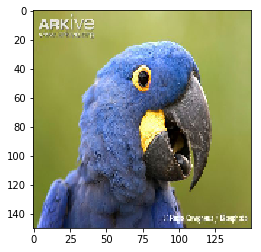

In [4]:
plt.imshow(img_tensor[0])
plt.show()

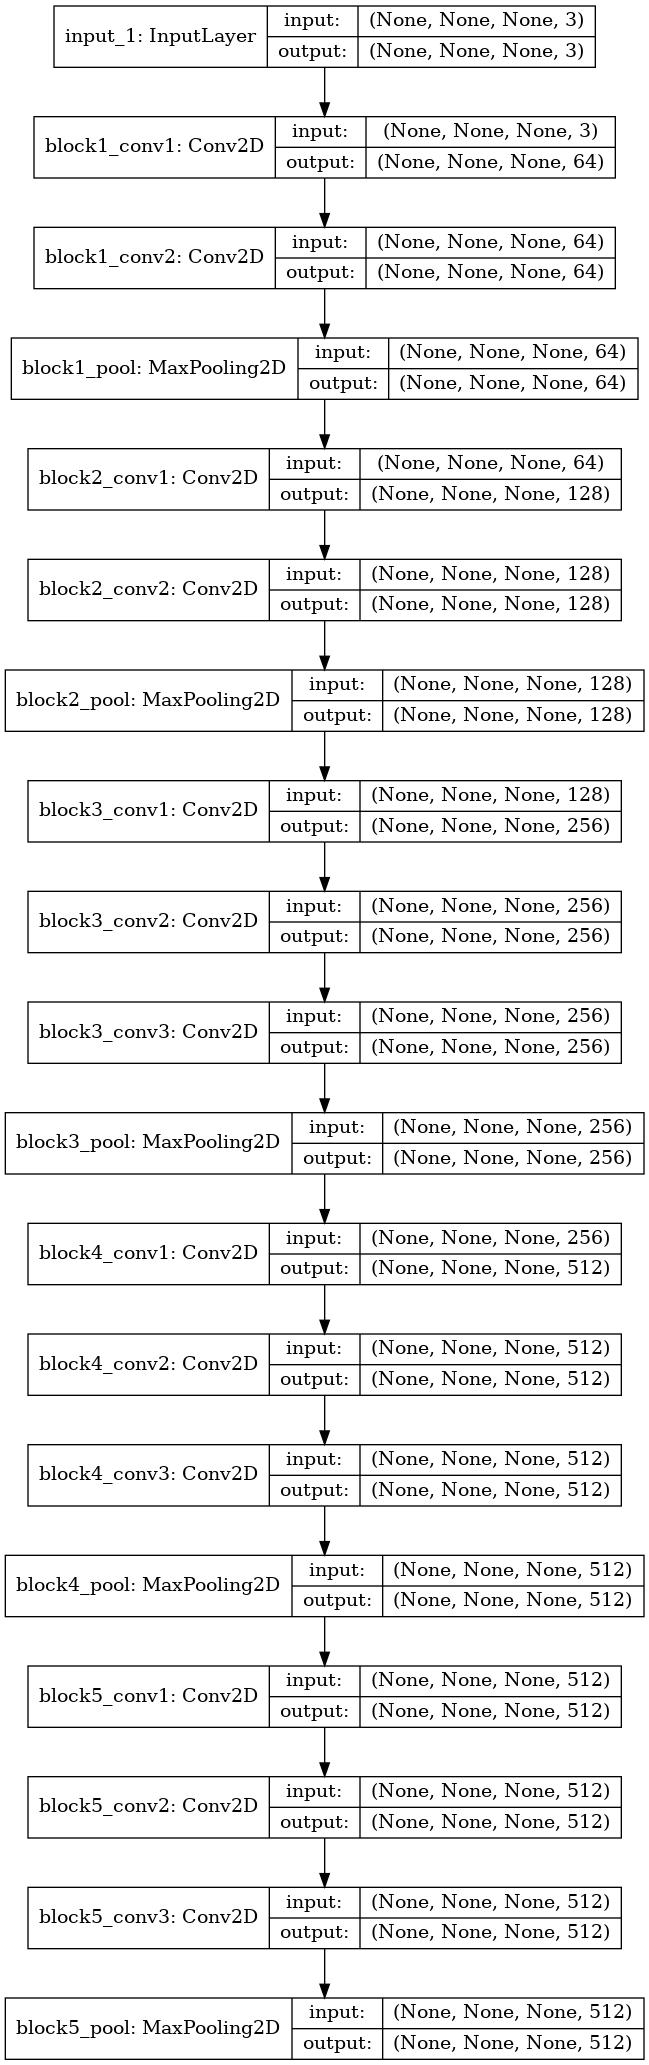

In [5]:
from keras import backend as K
from keras.utils import plot_model
import IPython

vgg=VGG16(weights='imagenet', include_top=False)

plot_model(vgg, to_file='vgg16.png', show_shapes=True, show_layer_names=True)

IPython.display.Image('vgg16.png')

In [6]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
def generate_pattern(layer_name, filter_index, size=150):
    
    layer_output = vgg.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, vgg.input)[0]

    # gradient normalization trick - lifted from google result ;
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([vgg.input], [loss, grads])
    
    # start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

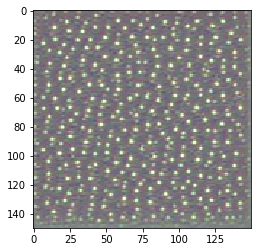

In [8]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

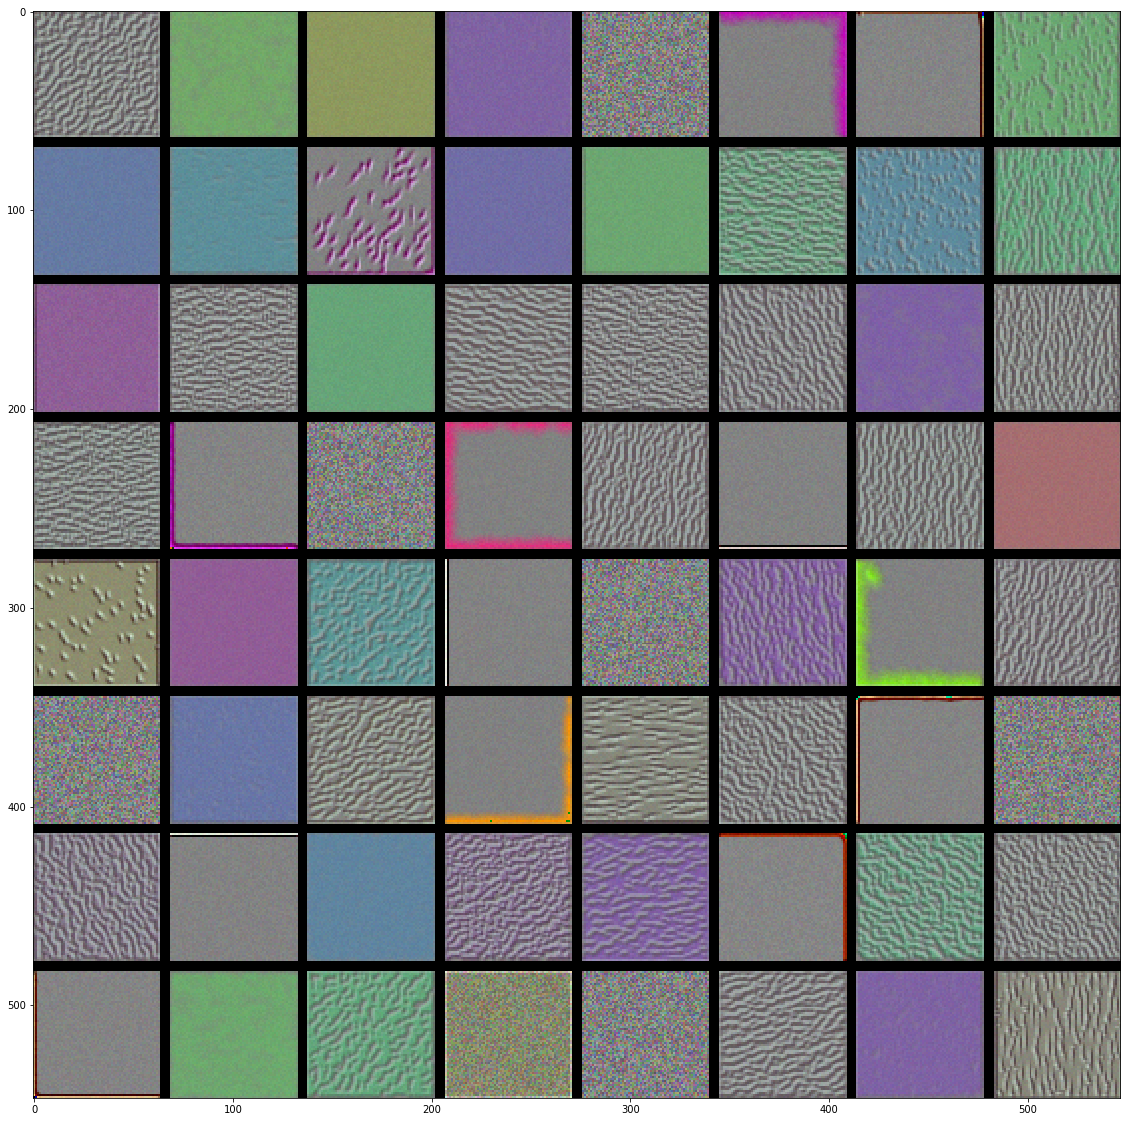

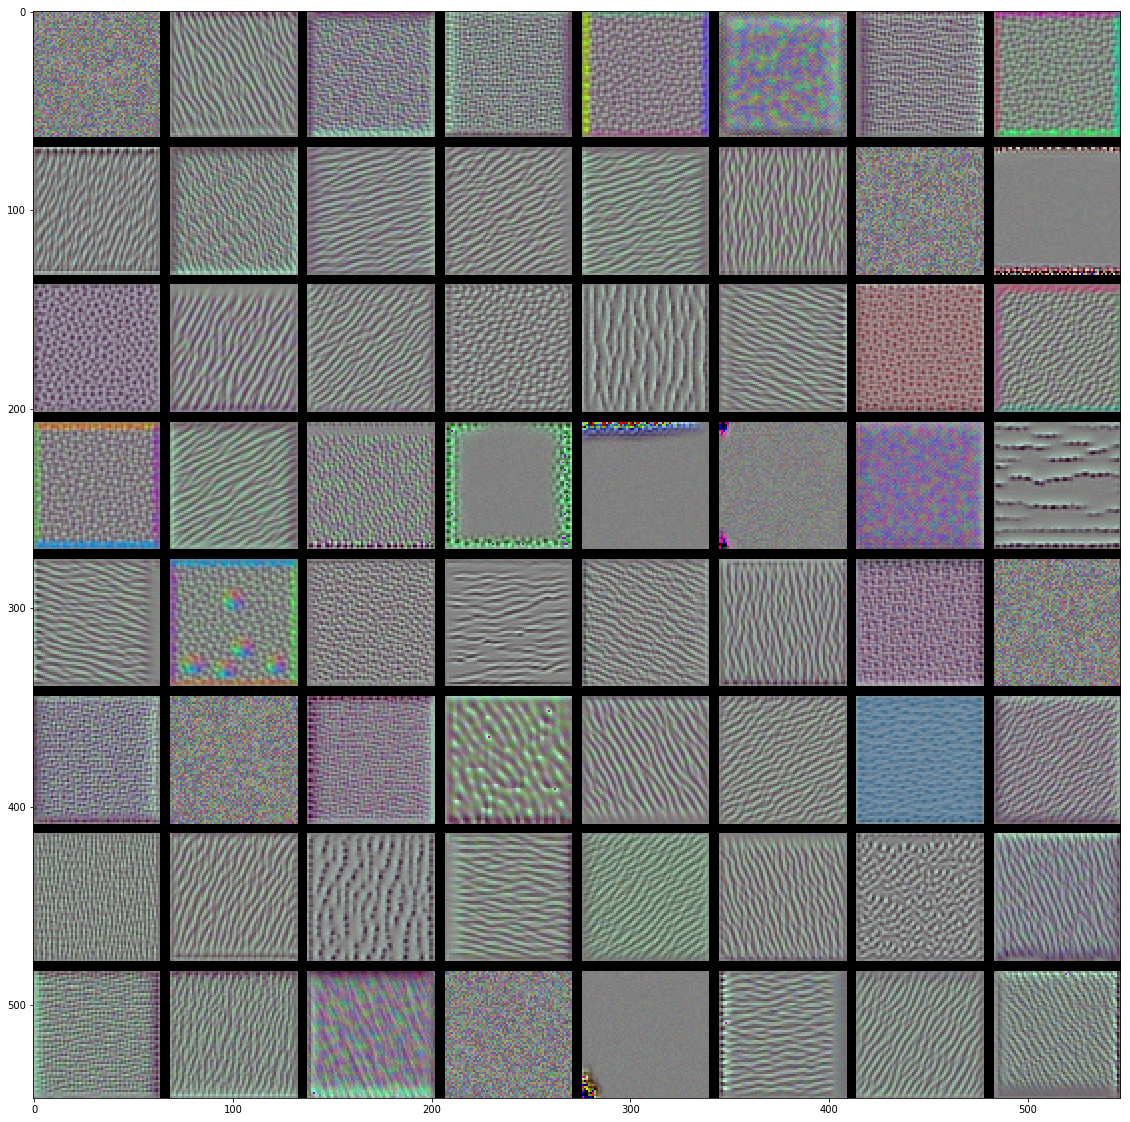

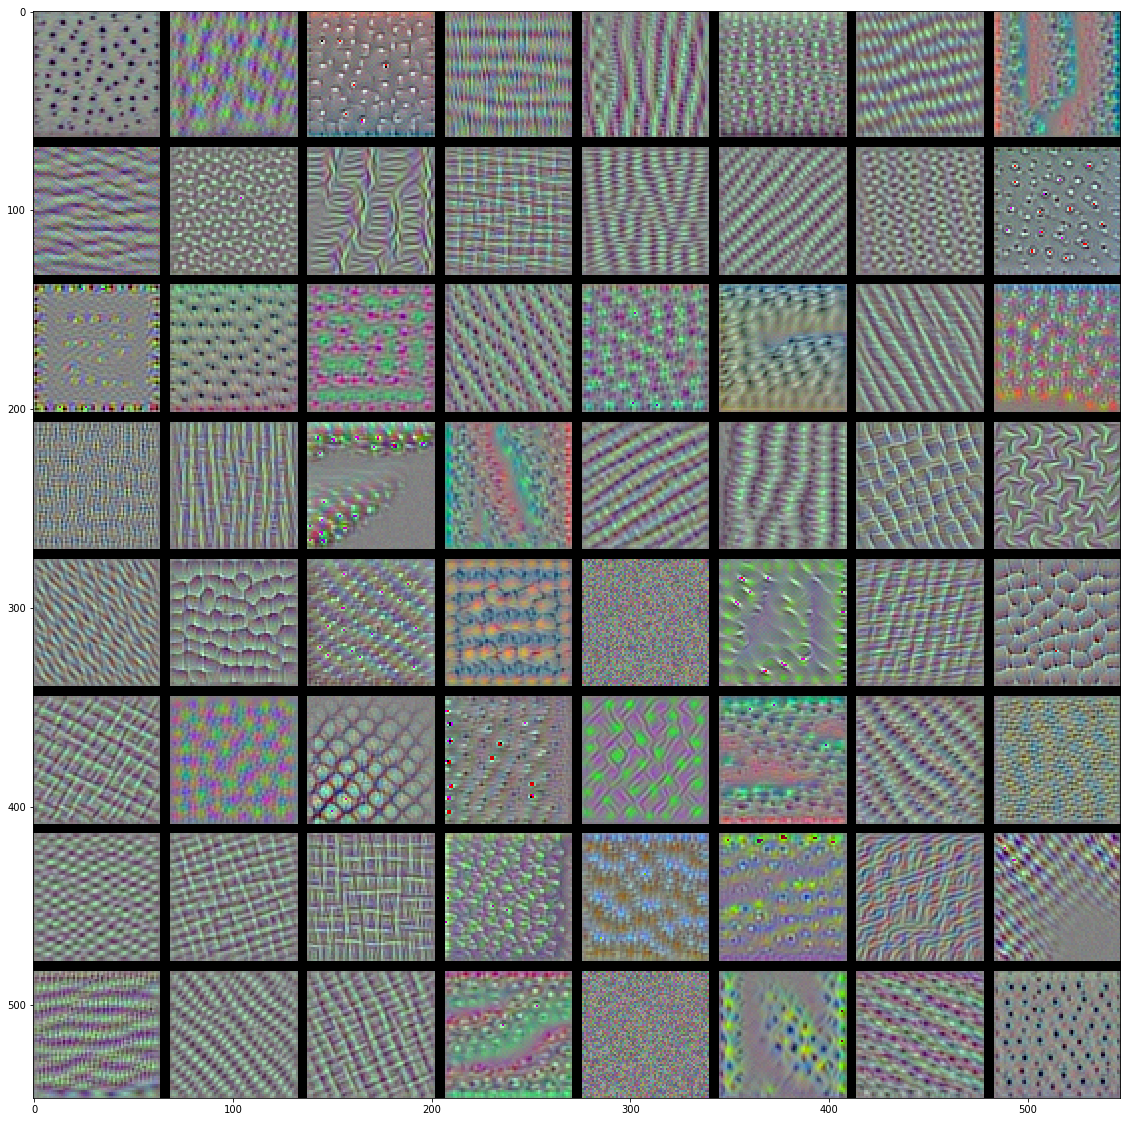

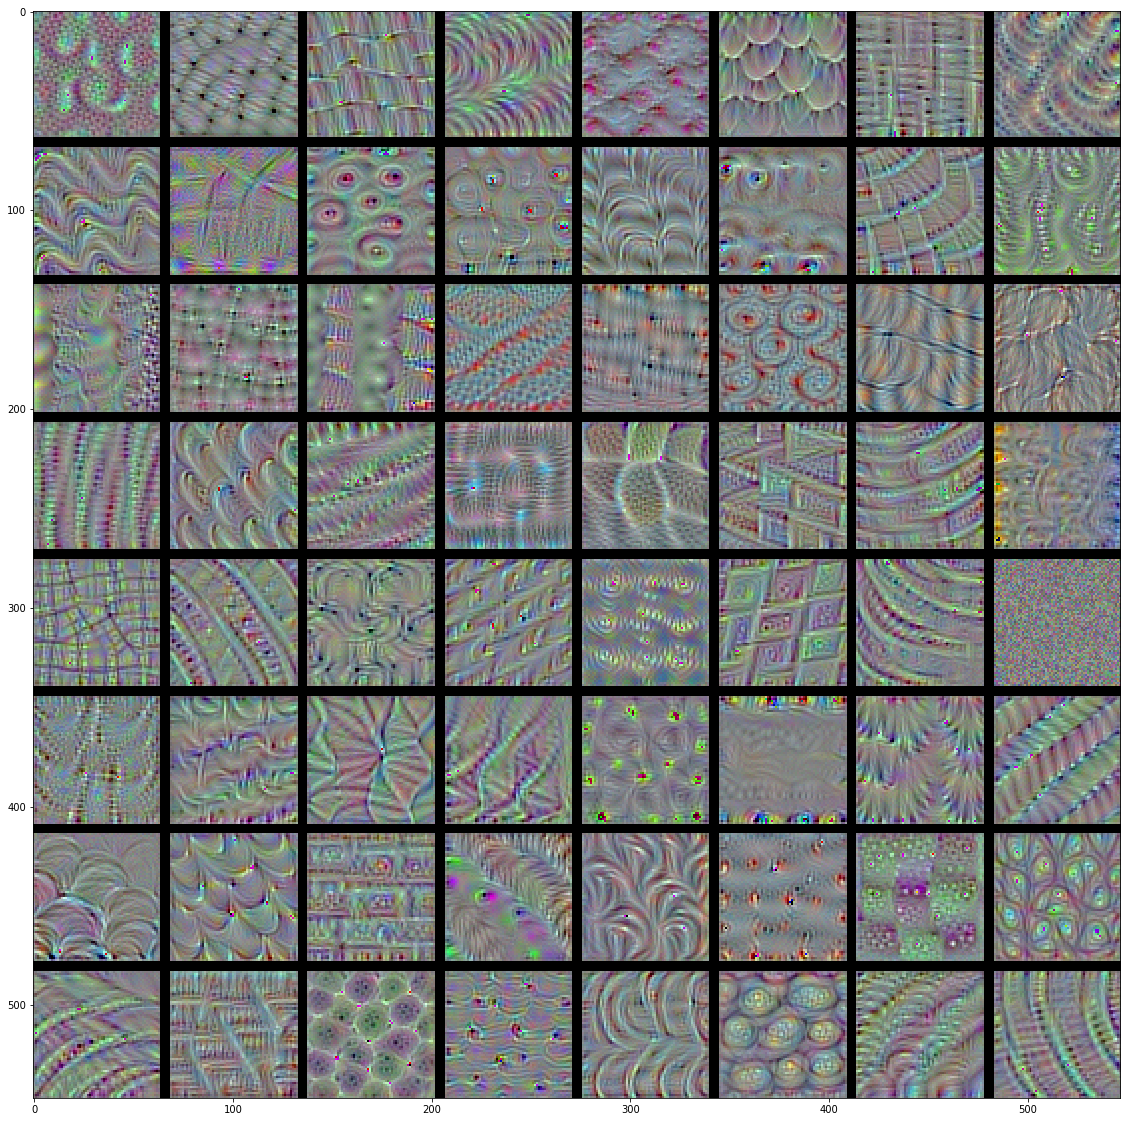

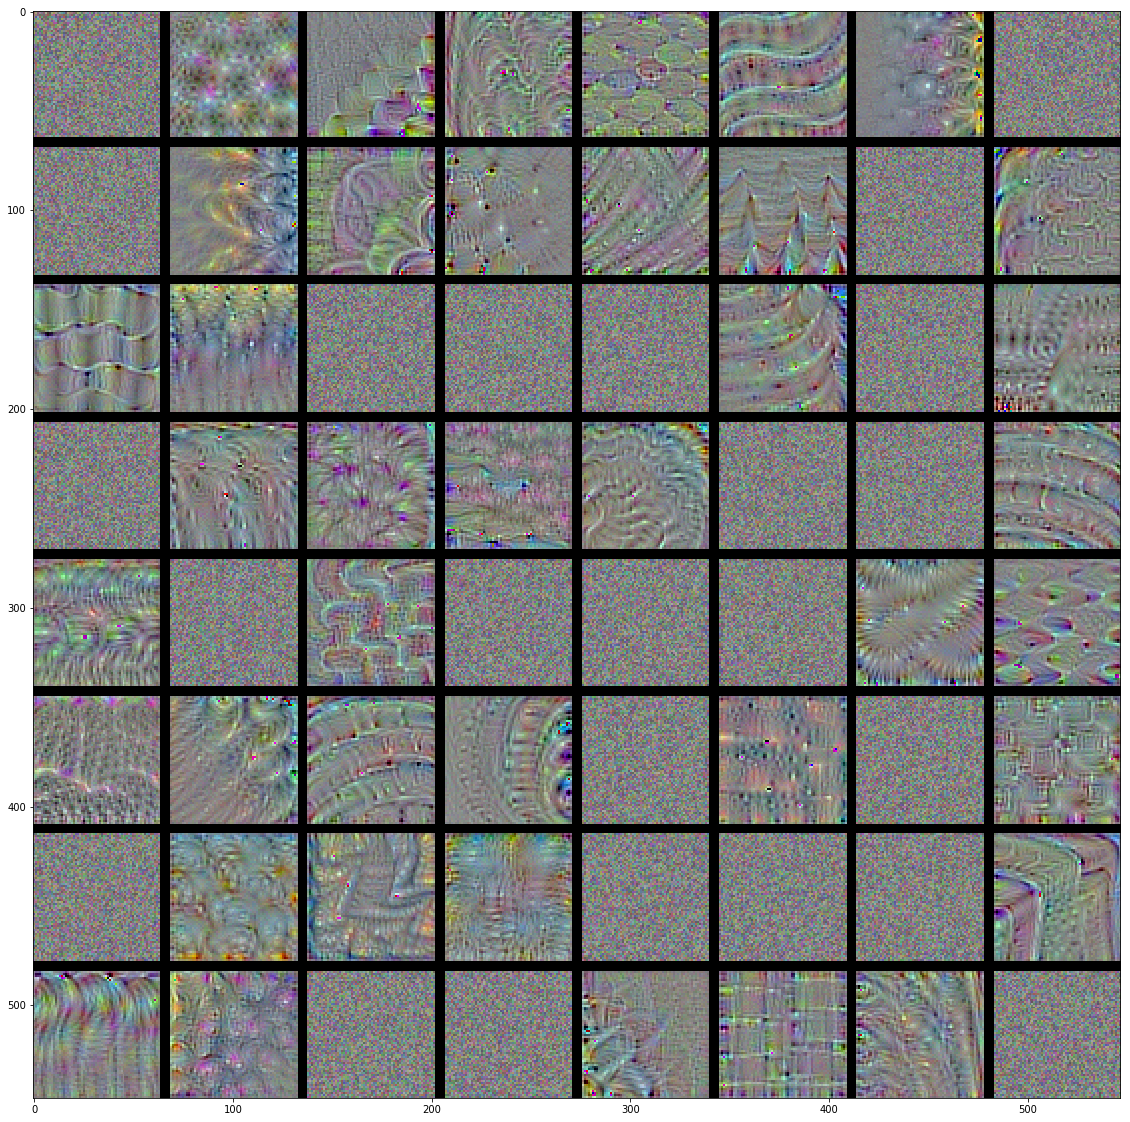

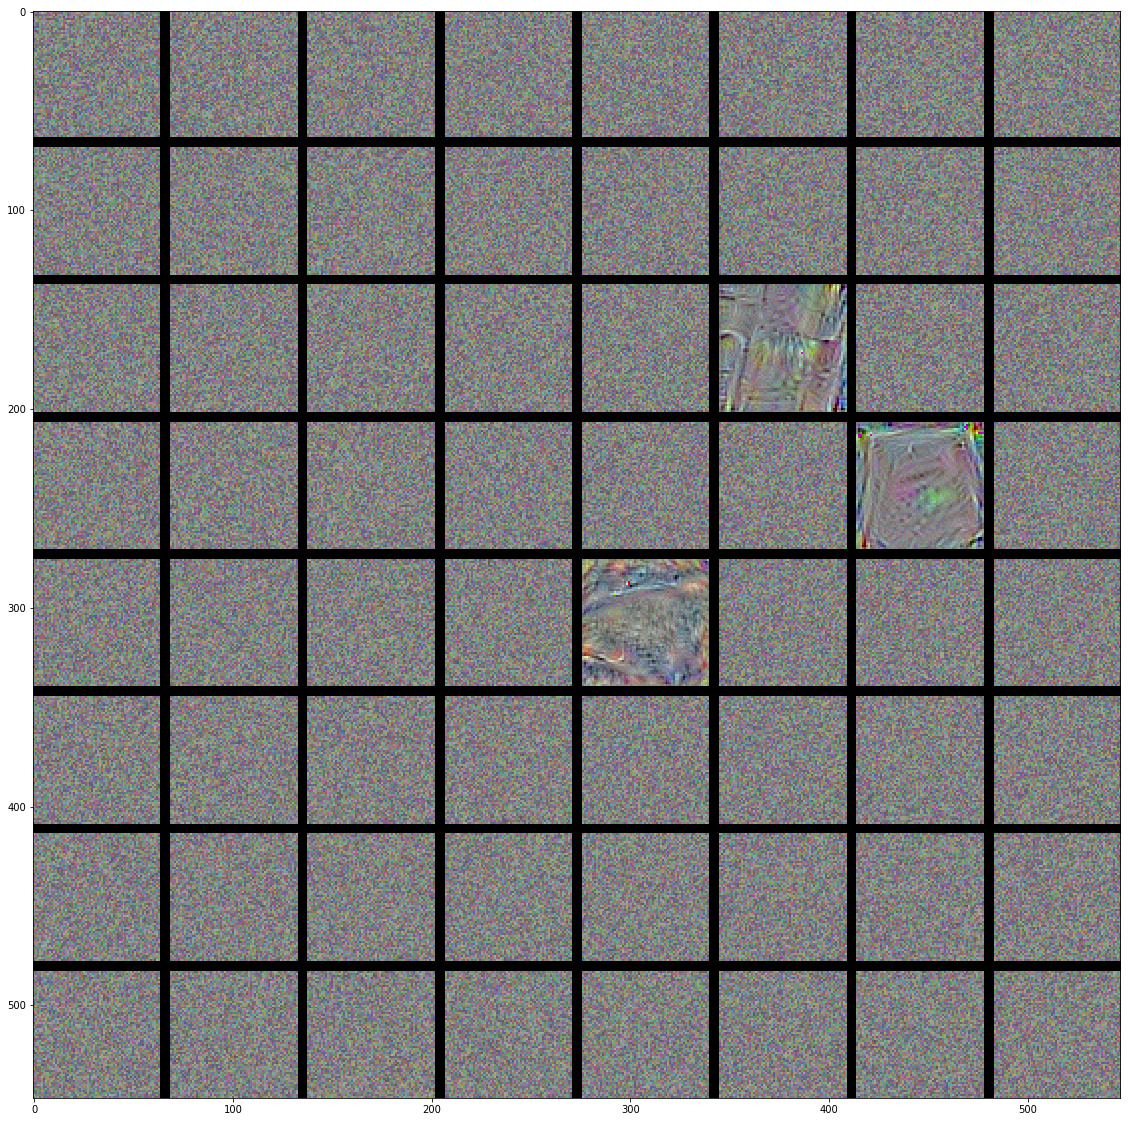

In [10]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block4_conv3', 'block5_conv3']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()